In [ ]:
import numpy as np #numpy for math operation
import os
from utils import concatenate_scan_set, makeSparseDataFromRasterRepeat, computeVLIV, vlivCPUFitExp, load_nested_data_pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from time import time
from tqdm import tqdm
import cv2
from natsort import natsorted

data_path = "/Users/akapatil/Documents/OCT/timelapse/inter_volume_registered/Timelapse_without_H2O2/registered_cropped_top"
average_LivCurve = True
fitting_method = "CPU"
frameSeparationTime = 1 #1ms frame to frame time interval
alivInitial  = 20 #initla guess for aliv parameter curve fitting
swiftInitial = 1 # initial guess for swiftness parameter curve fitting
bounds = (0, np.inf)

In [3]:
image_list = os.listdir(data_path)#list all images address in data_path
fourD_image_volume_complete = load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array
# fourD_image = fourD_image_volume_complete[:, 40:50, 30:50, 200:254]
fourD_image = fourD_image_volume_complete[:20,:,10:-10,:50].astype(np.float64)

In [4]:
concatenate_set = concatenate_scan_set(fourD_image)

In [5]:
concatenate_set.shape

(10000, 80, 50)

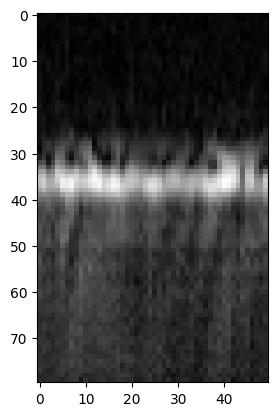

In [6]:
plt.imshow(concatenate_set[0], cmap="gray")

In [7]:
blockRepeat = fourD_image.shape[0]

blockPerVolume = 1 #only 1 block is used in our protocal
bscanLocationPerBlock = fourD_image.shape[1] #the number of B-scan in one 3D volume

In [8]:
numLocation = bscanLocationPerBlock * blockPerVolume # Number of total B-scan

print('Processing: ' + data_path)

## OCT intensity
height = concatenate_set.shape[1]
width = concatenate_set.shape[2]

aliv = np.zeros((numLocation, height, width), dtype=np.float64)
swift = np.zeros((numLocation, height, width),  dtype=np.float64)

Processing: /Users/akapatil/Documents/OCT/timelapse/inter_volume_registered/Timelapse_without_H2O2/registered_cropped_top


In [9]:
for floc in tqdm(range(0,numLocation)):

    # fpg = bscanLocationPerBlock*blockRepeat # frames/group
    # theGrp = int(floc/bscanLocationPerBlock) # The group containing the location (loc)
    # fIdxInG = floc - theGrp*bscanLocationPerBlock # The frame index in the group

    # fStart = fpg * theGrp + fIdxInG # The start frame index in the volume of the location.
    # fStop = fStart + (fpg - fIdxInG) - 1
    # frameIndexes = range(int(fStart), int(fStop) + 1, int(bscanLocationPerBlock))
    # timePoints = np.linspace(0,blockRepeat-1, blockRepeat, dtype = int)*bscanLocationPerBlock

    # sparseSequence = np.array(concatenate_set[np.array(frameIndexes).astype(int) , :, :])

    # print(floc)
    sparseSequence, timePoints = makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)


    if floc == 0: #for save VLIV array
        VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width),  dtype=np.float64)

    
    ## Compute VLIV
    VLIV , possibleMtw , VoV = computeVLIV(sparseSequence, timePoints, maxTimeWidth =  np.nan, compute_VoV = False)
    
    ## Average LIV curve
    if average_LivCurve == True:
        twIdx = 0
        for twIdx in range(0, VLIV.shape[0]):                
            VLIV[twIdx,:,:] = cv2.blur(VLIV[twIdx,:,:], (3,3))
            twIdx = twIdx + 1

    ## curve fitting on LIV curve to compute saturation level (magnitude) and time constant (tau)
    # if fitting_method == 'GPU':
    #     mag, tau = vlivGpuFitExp(VLIV, possibleMtw, VoV, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint, use_weight)
    
    if fitting_method == 'CPU':
        mag, tau = vlivCPUFitExp(VLIV, possibleMtw, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint = False)

    aliv [floc] = mag ## aLIV
    swift [floc] = 1/ tau ## Swiftness
    VLIV_save[floc,:,:,:] = VLIV ## LIV curve (VLIV)
        

  0%|          | 0/500 [00:00<?, ?it/s]/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


In [24]:
tau

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [52]:
# with open("swift_Yusuno.npy", "wb") as f:
#     np.save(f, swift)

# with open("aliv_Yusuno.npy", "wb") as f:
#     np.save(f, aliv)

# with open("VLIV_Yusuno.npy", "wb") as f:
#     np.save(f, VLIV_save)

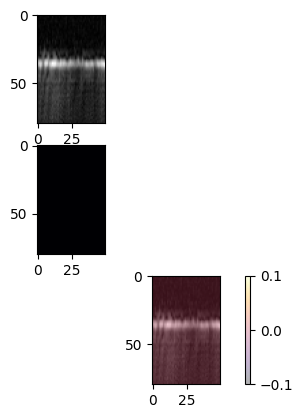

In [13]:
swift_normalized = cv2.normalize(swift[5, :, :,], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
fourD_normalized = cv2.normalize(fourD_image[10, 5, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 60), ncols=3)
# fo = ax1.imshow(fourD_normalized, cmap="gray")
# sw = ax2.imshow(swift_normalized, cmap="inferno")
# co_n = ax3.imshow(fourD_normalized, cmap="gray")
# co_s = ax3.imshow(swift_normalized, cmap="inferno", alpha = 0.4)
# fig.colorbar(co_s, ax=ax3)

plt.subplot(3, 1, 1)
plt.imshow(fourD_normalized, cmap="gray")
plt.subplot(3, 1, 2)
plt.imshow(swift_normalized, cmap="inferno")
plt.subplot(3, 1, 3)
plt.imshow(fourD_normalized, cmap="gray")
plt.imshow(swift_normalized, cmap="inferno", alpha=0.3)
plt.colorbar()

In [14]:
VLIV_save.shape

(500, 19, 80, 50)

Text(0, 0.5, 'AVG_LIV')

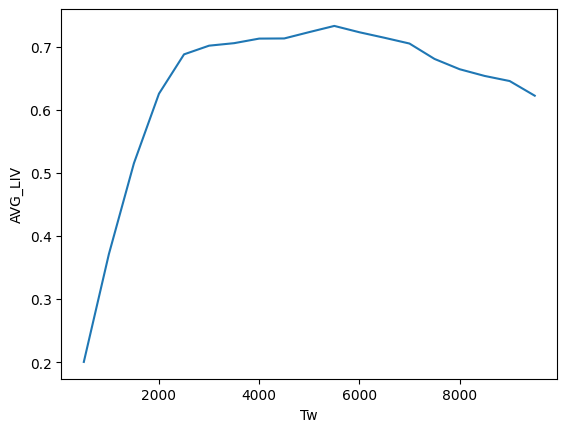

In [19]:
plt.plot(possibleMtw, VLIV_save[20, :, 40, 25])
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")

In [ ]:
VLIV_save[20, :, 40, 25]

array([0.20039346, 0.37130406, 0.51540002, 0.62571656, 0.6881011 ,
       0.70186933, 0.70584132, 0.71308911, 0.71331   , 0.72340263,
       0.73318433, 0.72314497, 0.71440708, 0.70524944, 0.68083434,
       0.66454549, 0.65387907, 0.64578361, 0.62253511])

Fitted Parameters:
A = 4.81770386307058
k = 0.4957020958908077
b = 2.0050198768972525

Covariance Matrix:
[[0.05013363 0.00615431 0.00067909]
 [0.00615431 0.0015243  0.00024041]
 [0.00067909 0.00024041 0.00011712]]


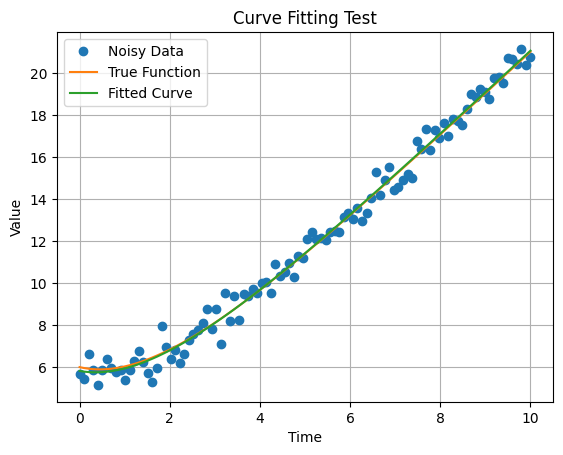

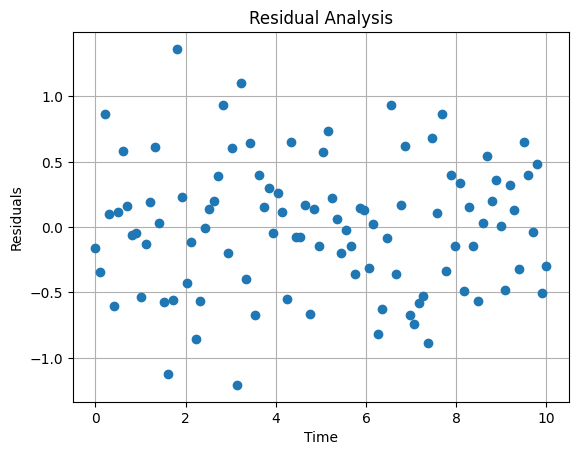


Example: Accessing elements
time_data[0]: 0.0
value_data[5]: 5.8758756639436935
fitted_curve[-1]: 21.08408577905946


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Time points
time = np.linspace(0, 10, 100)

# Underlying function (example: decaying exponential + linear)
true_function = 5 * np.exp(-0.5 * time) + 2 * time + 1

# Add noise
noise_level = 0.5
noise = np.random.normal(0, noise_level, len(time))
noisy_data = true_function + noise

# Store data in NumPy arrays
time_data = time  # or time_data = np.array(time) if you want a copy
value_data = noisy_data # or value_data = np.array(noisy_data)


# --- Curve Fitting ---
def fit_function(t, A, k, b):  # Example fit function (adjust as needed)
    return A * np.exp(-k * t) + b * t + 1

initial_guesses = [50, 50, 200]  # Important: Provide good initial guesses

popt, pcov = curve_fit(fit_function, time_data, value_data, p0=initial_guesses,bounds=bounds)

A_fit, k_fit, b_fit = popt

print("Fitted Parameters:")
print(f"A = {A_fit}")
print(f"k = {k_fit}")
print(f"b = {b_fit}")
print("\nCovariance Matrix:")
print(pcov)

fitted_curve = fit_function(time, A_fit, k_fit, b_fit)  # Use original time array for plotting

# --- Plotting ---
plt.plot(time, noisy_data, 'o', label='Noisy Data')
plt.plot(time, true_function, '-', label='True Function')
plt.plot(time, fitted_curve, '-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Curve Fitting Test')
plt.grid(True)
plt.show()


# --- Further Analysis (Example: Residuals) ---
residuals = value_data - fitted_curve # Calculate the difference between the actual and predicted values

plt.figure() # Create a new plot
plt.plot(time, residuals, 'o')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()

# --- Example: Accessing elements ---
print("\nExample: Accessing elements")
print("time_data[0]:", time_data[0])
print("value_data[5]:", value_data[5])
print("fitted_curve[-1]:", fitted_curve[-1])  # Last element